In [12]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import models

# Import custom dataset class
from utils.dataset import SolarPanelDataset

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
list_models()

NameError: name 'list_models' is not defined

In [3]:
dataset_name = "Kasmi_2023"

## Create Dataset Class

In [4]:
import os
import torch

from torchvision.io import read_image, ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torch.utils.data import Dataset
import numpy as np
from PIL import Image


class SolarPanelDataset(Dataset):
    def __init__(self, root, transforms):
        # root directory for the dataset
        self.root = root
        # transformations to be applied on the images and masks
        self.transforms = transforms

        # os.path.join is used to combine parts of a path in a platform-independent way
        # os.listdir returns a list of all files in the specified directory
        # sorted() is used to sort the list of files, ensuring that the images and masks align

        # load all image files from the "images" directory inside the root directory
        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        # load all mask files from the "masks" directory inside the root directory
        self.masks = list(sorted(os.listdir(os.path.join(root, "mask"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        img = read_image(img_path, mode=ImageReadMode.RGB)

        mask_path = os.path.join(self.root, "mask", self.masks[idx])
        mask = read_image(mask_path, mode=ImageReadMode.RGB)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYWH", canvas_size=F.get_size(img)
        )
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            if isinstance(img, Image.Image) or isinstance(img, np.ndarray):
                img = self.transforms(img)  # earlier version had (img, target)

        return img, mask, target

    def __len__(self):
        return len(self.imgs)

## Train-Test-Val-Split & Transformations

This code is defining a series of transformations that will be applied to the images in your dataset.

`transforms.Compose` is a function from the PyTorch library that composes several transformations together. It takes a list of transformations and applies them in the order they are provided.

Here are the transformations being applied:

1. `transforms.ToTensor()`: This transformation converts a PIL Image or a numpy.ndarray to a PyTorch tensor. It also scales the image's pixel intensity values in the range 0-255 to a float in the range 0.0-1.0.

2. `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: This transformation normalizes a tensor image with mean and standard deviation. Given mean `(M1,...,Mn)` and std `(S1,..,Sn)` for `n` channels, this transform will normalize each channel of the input `torch.*Tensor` i.e., `output[channel] = (input[channel] - mean[channel]) / std[channel]`. Here, it's normalizing the image by setting the mean and standard deviation for all three color channels (Red, Green, Blue) to 0.5. This will shift the pixel intensity values from a range of [0,1] to [-1,1].

These transformations are commonly used when working with image data in PyTorch. They help to standardize the input data, making it easier for the neural network to learn from the data.

In [5]:
# Define the transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Define the root directory
root_dir = f"data/{dataset_name}"

# Create the full dataset
full_dataset = SolarPanelDataset(root_dir, transform)

# Define the sizes of your splits
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Create the datasets
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

There are several common transformations used in PyTorch, especially when dealing with image data. Here are a few:

1. `transforms.Resize(size)`: Resizes the input image to the given size.

2. `transforms.CenterCrop(size)`: Crops the image at the center to have a size equal to the provided size.

3. `transforms.RandomCrop(size)`: Crops the image at a random location to have a size equal to the provided size.

4. `transforms.RandomHorizontalFlip()`: Horizontally flips the image with a given probability (default is 0.5).

5. `transforms.RandomVerticalFlip()`: Vertically flips the image with a given probability (default is 0.5).

6. `transforms.RandomRotation(degrees)`: Rotates the image by a random angle within the given range of degrees.

7. `transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)`: Randomly changes the brightness, contrast, and saturation of an image.

8. `transforms.Grayscale(num_output_channels=1)`: Converts the image to grayscale.

9. `transforms.Pad(padding, fill=0, padding_mode='constant')`: Pads the image on all sides with the specified padding value.

10. `transforms.ToPILImage()`: Converts a tensor or an ndarray to PIL Image.

These transformations can be used to augment the data, which can help improve the performance of the model by providing more varied data for training. The appropriate transformations to use depend on the specific task and the nature of the input data.

In [6]:
sample = train_dataset[0]
print(
    f"The type of the train_dataset sample is: {type(sample)}"
)  # Print the type of the sample
print(
    f"The number of items in the sample is: {len(sample)}"
)  # Print the number of items in the sample

# If the sample is a tuple containing an image and a label
image, mask, target = sample
print(f"The type of the image is: {type(image)}")  # Print the type of the image
print(f"The size of the image is: {image.size()}")  # Print the size of the image

print(f"The mask file looks like this: {mask}")  # Print the label

# Print the keys in the dictionary
print(f"The keys in the target dictionary are: {target.keys()}")

# Print the values in the dictionary
print(f"The values in the target dictionary are: {target.values()}")

# Print the entire dictionary
print(f"The target dictionary is: {target}")

The type of the train_dataset sample is: <class 'tuple'>
The number of items in the sample is: 3
The type of the image is: <class 'torchvision.tv_tensors._image.Image'>
The size of the image is: torch.Size([3, 400, 400])
The mask file looks like this: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
The keys in the target dictionary are: dict_keys(['

In [7]:
full_dataset

In [8]:
print(
    f"The trainset has {train_size} images. The validation set has {val_size} images. The testset has {test_size} images."
)

The trainset has 9312 images. The validation set has 1995 images. The testset has 1996 images.


In [9]:
train_loader

In [10]:
# Define a Model
class SolarPanelDetector(nn.Module):
    def __init__(self):
        super(SolarPanelDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 97 * 97, 120)  # Adjusted to match the actual size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3 * 400 * 400)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 97 * 97)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1, 3, 400, 400)


# Instantiate the model
model = SolarPanelDetector()

# Define a loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, _ = data

        # Convert inputs and labels to float tensors
        inputs = inputs.float()
        labels = labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Batch {i + 1}/{len(train_loader)}")
            print(f"Loss: {loss.item()}")

print("Finished Training")

AttributeError: module 'torchvision.transforms.v2.functional' has no attribute 'relu'

In [ ]:
# Create the directory if it doesn't exist
if not os.path.exists("model"):
    os.makedirs("model")

version = 0
filename = f"model/model_{dataset_name}.pth"

# Check if the file exists and increment version number until a unique filename is found
while os.path.exists(filename):
    version += 1
    filename = f"model_{dataset_name}_v{version}.pth"

# Save the model
torch.save(model.state_dict(), filename)

In [ ]:
model.eval()
with torch.no_grad():
    for data in val_loader:
        print(data)  # Temporarily print data to inspect its structure
        break  # Break after the first batch to avoid printing too much data

[tensor([[[[ 84,  91,  91,  ..., 195, 195, 195],
          [ 89,  92,  91,  ..., 195, 195, 195],
          [ 91,  92,  91,  ..., 195, 195, 195],
          ...,
          [128, 186, 215,  ..., 166, 166, 166],
          [174, 215, 243,  ..., 174, 166, 158],
          [226, 251, 251,  ..., 166, 166, 158]],

         [[ 84,  91,  91,  ..., 195, 195, 195],
          [ 89,  96,  91,  ..., 195, 195, 195],
          [ 91,  96,  91,  ..., 195, 195, 195],
          ...,
          [139, 187, 215,  ..., 166, 166, 166],
          [174, 215, 243,  ..., 174, 166, 158],
          [226, 251, 251,  ..., 166, 166, 158]],

         [[ 74,  84,  84,  ..., 179, 179, 179],
          [ 74,  80,  84,  ..., 179, 179, 179],
          [ 84,  80,  84,  ..., 179, 179, 179],
          ...,
          [124, 179, 203,  ..., 159, 159, 159],
          [163, 203, 235,  ..., 163, 159, 154],
          [214, 235, 235,  ..., 159, 159, 154]]],


        [[[215, 251, 255,  ...,  28,  36,  56],
          [227, 215, 215,  ...,  4

In [ ]:
from sklearn.metrics import precision_score, recall_score, jaccard_score


def evaluate(predictions, targets):
    # Extract the relevant data from the targets dictionary
    labels = targets["labels"].numpy()

    # Flatten labels and predictions
    labels = labels.flatten()
    predictions = (predictions > 0.5).numpy().flatten()

    # Check that labels and predictions have the same total size
    assert (
        labels.size == predictions.size
    ), "labels and predictions must have the same total size"

    # Calculate metrics
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    IoU = jaccard_score(labels, predictions, average="weighted")

    return precision, recall, IoU

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    for images, masks, targets in val_loader:
        images = images.float()  # Convert images to float
        predictions = model(images)

        # Evaluate the model's performance on the validation set
        precision, recall, IoU = evaluate(predictions, targets)
        print(f"Precision: {precision.item()}")
        print(f"Recall: {recall.item()}")
        print(f"IoU: {IoU.item()}")

        # Make predictions on new images
        new_image = torch.randn((1, 3, 224, 224))
        prediction = model(new_image)

        # Apply post-processing steps like non-maximal suppression (NMS) to refine the predictions
        refined_prediction = refine_prediction(prediction)

        # Visualize the predicted mask
        visualize_mask(refined_prediction)

AssertionError: labels and predictions must have the same total size

In [ ]:
def predict(model, input_tensor):
    # Set the model to evaluation mode
    model.eval()

    # Ensure no gradients are calculated
    with torch.no_grad():
        # Add an extra dimension for batch size
        input_tensor = input_tensor.unsqueeze(0)

        # Make sure the input tensor is on the same device as the model
        input_tensor = input_tensor.to(next(model.parameters()).device)

        # Get the model's predictions
        output = model(input_tensor)

        # Apply sigmoid function to get probabilities
        probabilities = torch.sigmoid(output)

    return probabilities.squeeze(0)

In [ ]:
val_dataset[0]

(Image([[[ 84,  91,  91,  ..., 195, 195, 195],
         [ 89,  92,  91,  ..., 195, 195, 195],
         [ 91,  92,  91,  ..., 195, 195, 195],
         ...,
         [128, 186, 215,  ..., 166, 166, 166],
         [174, 215, 243,  ..., 174, 166, 158],
         [226, 251, 251,  ..., 166, 166, 158]],
 
        [[ 84,  91,  91,  ..., 195, 195, 195],
         [ 89,  96,  91,  ..., 195, 195, 195],
         [ 91,  96,  91,  ..., 195, 195, 195],
         ...,
         [139, 187, 215,  ..., 166, 166, 166],
         [174, 215, 243,  ..., 174, 166, 158],
         [226, 251, 251,  ..., 166, 166, 158]],
 
        [[ 74,  84,  84,  ..., 179, 179, 179],
         [ 74,  80,  84,  ..., 179, 179, 179],
         [ 84,  80,  84,  ..., 179, 179, 179],
         ...,
         [124, 179, 203,  ..., 159, 159, 159],
         [163, 203, 235,  ..., 163, 159, 154],
         [214, 235, 235,  ..., 159, 159, 154]]], dtype=torch.uint8, ),
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          

In [ ]:
from torchvision import transforms
from PIL import Image

# Define the transformations
transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)  # Normalize the image

# Load the image
image = val_dataset[0][0]

# Convert the image to a float tensor
image = image.float()

# Apply the transformations
input_image = transform(image)

# Use the model to make a prediction
predictions = predict(model, input_image)

predictions

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

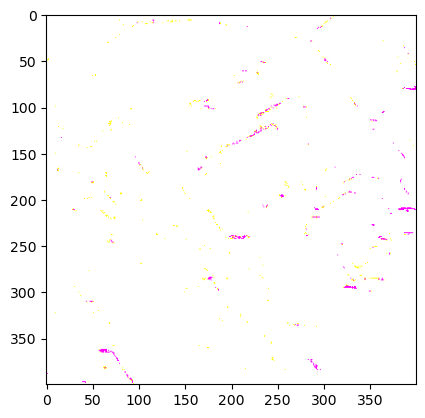

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the tensor to a numpy array
numpy_image = input_image.numpy()

# Transpose the dimensions to (height, width, channels)
numpy_image = np.transpose(numpy_image, (1, 2, 0))

# Denormalize the image
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
numpy_image = std * numpy_image + mean

# Clip the values to be between 0 and 1
numpy_image = np.clip(numpy_image, 0, 1)

# Display the image
plt.imshow(numpy_image)
plt.show()

In [ ]:
from matplotlib.patches import Rectangle

# Assuming predicted_boxes and predicted_masks are available
predicted_boxes = model.predict_boxes(image_tensor)
predicted_masks = model.predict_masks(image_tensor)

# Convert the prediction tensors to numpy arrays
predicted_boxes = predicted_boxes.numpy()
predicted_masks = predicted_masks.numpy().argmax(
    axis=0
)  # Convert to single-channel mask

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Display the original image in the first subplot
axs[0].imshow(image_numpy)
axs[0].set_title("Original Image")

# Display the predicted bounding boxes in the second subplot
axs[1].imshow(image_numpy)
for box in predicted_boxes:
    rect = Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    axs[1].add_patch(rect)
axs[1].set_title("Predicted Bounding Boxes")

# Display the predicted mask in the third subplot
axs[2].imshow(predicted_masks, cmap="gray")  # Use a grayscale colormap for the mask
axs[2].set_title("Predicted Mask")

# Show the figure
plt.show()

AttributeError: 'SolarPanelDetector' object has no attribute 'predict_boxes'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


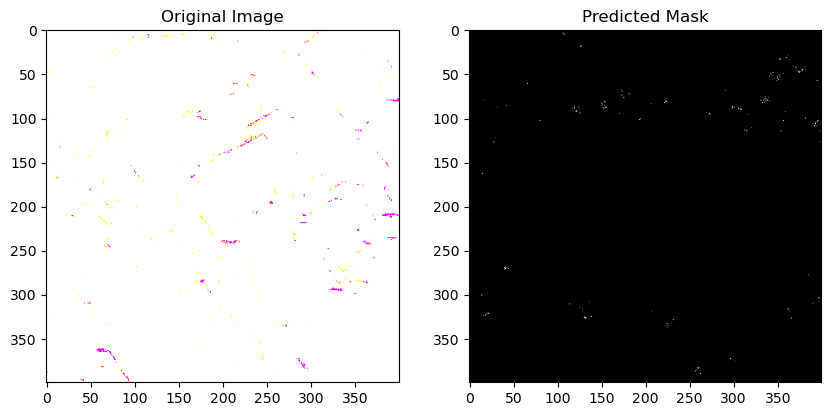

In [ ]:
# Convert the prediction tensor to a single-channel mask
predicted_mask = predictions.numpy().argmax(axis=0)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image in the first subplot
axs[0].imshow(original_numpy_image)
axs[0].set_title("Original Image")

# Display the predicted mask in the second subplot
axs[1].imshow(predicted_mask, cmap="gray")  # Use a grayscale colormap for the mask
axs[1].set_title("Predicted Mask")

# Show the figure
plt.show()